# Imports

In [1]:
import os
import tensorflow as tf
from tensorflow.python import keras
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Embedding, LSTM
from keras import regularizers, layers, preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

# Data Preprocessing

In [2]:
data_raw = np.load('./data/dataset.npy', allow_pickle=True)
print(type(data_raw))
print(data_raw.ndim)

<class 'numpy.ndarray'>
0


In [3]:
data_raw

array({'resistant': array([False, False, False, ...,  True,  True, False]), 'genes': array(['ATGCACTACCGTATGATCCCCCTTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACCCGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATCGTGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       ...,
       'ATGCACTACCGTATGATTCACTGGATGATGGAAACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTAC

In [12]:
# data to dict
data_dict = data_raw[()]

# dict to df
data_df = pd.DataFrame.from_dict(data_dict)

data_df

,resistant,genes
0,False,ATGCACTACCGTATGATCCCCCTTCACTGGATGATGGAAATTGACT...
1,False,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...
2,False,ATGCACTACCGTATGATTCACTGGATCGTGATGGAAATTGACTGCA...
3,False,ATGCACTACCGTATGATTCACTGGGTGATGGAAATTGACTGCAATG...
4,False,ATGCACGACCGTATCATTCACTGGATGATGGAAATTGACTGCAATG...
...,...,...
99995,False,ATGCACTACCGTATGATTCACTGGATGATGGAAACTCTCTTTGACT...
99996,False,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...
99997,True,ATGCACTACCGTATGATTCACTGGATGATGGAAACTGCAATGGCTG...
99998,True,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTTGCAAT...


## Data exploration

In [14]:
len(data_df[data_df.isna().any(axis=1)])

0

In [15]:
# set uniform lengths
data_df.fillna('').astype(str).apply(lambda x:x.str.len()).max()

resistant      5
genes        156
dtype: int64

In [16]:
len(data_df[data_df.resistant]) / len(data_df)

0.49703

## Preprocess

In [7]:
# Tokenize from characters to integers 
maxlen = 160 # cut off after this number of characters in a string

max_words = 4 # considers only characters in the dictionary A C T G
max_features = max_words

tokenizer = Tokenizer(num_words=max_words, char_level=True)
tokenizer.fit_on_texts(list(data_df['genes']))

# sequences and then pad / truncate data
sequences = tokenizer.texts_to_sequences(list(data_df['genes']))
Xpad = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post', value=0)

print('Found %s unique tokens.' % len(tokenizer.word_index))
print('word_index', tokenizer.word_index)

Found 4 unique tokens.
word_index {'a': 1, 't': 2, 'c': 3, 'g': 4}


## Separate the label

In [8]:
labels = np.asarray(data_df['resistant'])
print(Xpad.shape)
print(labels.shape)

(100000, 160)
(100000,)


In [9]:
# Check a sample

rowNum = 3
print(data_df['genes'][rowNum])
print(sequences[rowNum])
print(Xpad[rowNum])
print(labels[rowNum])

ATGCACTACCGTATGATTCACTGGGTGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA
[1, 2, 3, 1, 3, 2, 1, 3, 3, 2, 1, 2, 1, 2, 2, 3, 1, 3, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 3, 2, 3, 1, 1, 2, 3, 2, 3, 3, 2, 1, 1, 2, 1, 1, 2, 1, 3, 2, 2, 2, 2, 3, 2, 3, 2, 3, 2, 2, 1, 1, 2, 2, 1, 3, 1, 3, 2, 2, 3, 2, 3, 1, 3, 1, 1, 1, 3, 1, 3, 2, 2, 1, 1, 3, 1, 2, 2, 1, 1, 1, 2, 3, 2, 1, 3, 3, 2, 3, 1, 3, 1, 1, 2, 1, 2, 2, 3, 2, 1, 3, 3, 1, 1, 3, 2, 2, 1]
[1 2 3 1 3 2 1 3 3 2 1 2 1 2 2 3 1 3 2 2 1 2 1 1 1 2 2 1 3 2 3 1 1 2 3 2 3
 3 2 1 1 2 1 1 2 1 3 2 2 2 2 3 2 3 2 3 2 2 1 1 2 2 1 3 1 3 2 2 3 2 3 1 3 1
 1 1 3 1 3 2 2 1 1 3 1 2 2 1 1 1 2 3 2 1 3 3 2 3 1 3 1 1 2 1 2 2 3 2 1 3 3
 1 1 3 2 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
False


## Create train, val, and test datasets

In [10]:
training_samples = int(Xpad.shape[0] * 0.9)
# The validation is being taken by keras - below
# test = remaining

indices = np.arange(Xpad.shape[0])
# np.random.shuffle(indices) # FOR TESTING PURPOSES comment it out - to keep indices as above

Xpad = Xpad[indices]
labels = labels[indices]

x_train = Xpad[:training_samples]
y_train = labels[:training_samples]
x_test = Xpad[training_samples: ]
y_test = labels[training_samples: ]

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)

x_train (90000, 160)
y_train (90000,)
x_test (10000, 160)
y_test (10000,)


# Train Model

## Sequential

In [11]:
# Model ... 128 CNN window 27 & Bidirectional GRU accuracy = 

# Define a Sequential model
model = Sequential()

# Embedding Layer: Maps integer indices to dense vectors of fixed size 
# (length 4 vocabulary size to 1 in this case)
model.add(Embedding(4, 1, input_length=maxlen))

# Convolutional Layer 1: 128 filters, window size 27
model.add(layers.Conv1D(128, 27, activation='relu'))

# MaxPooling Layer: Downsamples the output of the previous layer by taking the maximum value over a window of specified size (9 in this case)
model.add(layers.MaxPooling1D(9))

# Dropout Layer 1: Regularization technique to prevent overfitting by randomly setting a fraction of input units to 0 at each update
model.add(layers.Dropout(0.5))

# Convolutional Layer 2: 128 filters, window size 9, ReLU activation
model.add(layers.Conv1D(128, 9, activation='relu'))

# Dropout Layer 2: Regularization
model.add(layers.Dropout(0.5))

# Bidirectional GRU Layer: Gated Recurrent Unit with 32 units, dropout for input and recurrent connections
model.add(layers.Bidirectional(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2)))

# Dense Layer: Output layer with 1 unit and sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# Display a summary of the model architecture, including the number of parameters in each layer
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 160, 1)            4         
                                                                 
 conv1d (Conv1D)             (None, 134, 128)          3584      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 14, 128)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 6, 128)            147584    
                                                                 
 dropout_1 (Dropout)         (None, 6, 128)            0         
                                                        

In [12]:
### Train / Validate model

In [13]:
history = model.fit(x_train, y_train,
    epochs = 10,
    batch_size=32,
    validation_split=0.2)

Epoch 1/10
2250/2250 [==============================] - 26s 11ms/step - loss: 0.6570 - acc: 0.5686 - val_loss: 0.5562 - val_acc: 0.6671
Epoch 2/10
2250/2250 [==============================] - 23s 10ms/step - loss: 0.5178 - acc: 0.7059 - val_loss: 0.4533 - val_acc: 0.7413
Epoch 3/10
2250/2250 [==============================] - 35s 15ms/step - loss: 0.4693 - acc: 0.7349 - val_loss: 0.4200 - val_acc: 0.7669
Epoch 4/10
2250/2250 [==============================] - 31s 14ms/step - loss: 0.4456 - acc: 0.7513 - val_loss: 0.4095 - val_acc: 0.7820
Epoch 5/10
2250/2250 [==============================] - 20s 9ms/step - loss: 0.4349 - acc: 0.7584 - val_loss: 0.4022 - val_acc: 0.7846
Epoch 6/10
2250/2250 [==============================] - 18s 8ms/step - loss: 0.4236 - acc: 0.7636 - val_loss: 0.3939 - val_acc: 0.7856
Epoch 7/10
2250/2250 [==============================] - 17s 8ms/step - loss: 0.4167 - acc: 0.7681 - val_loss: 0.3909 - val_acc: 0.7808
Epoch 8/10
2250/2250 [=============================

### Learning curves

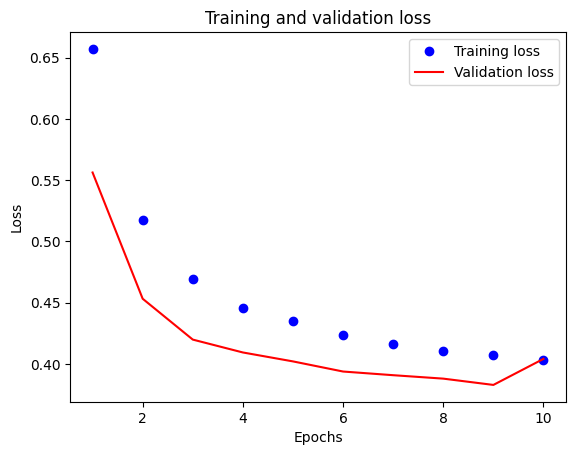

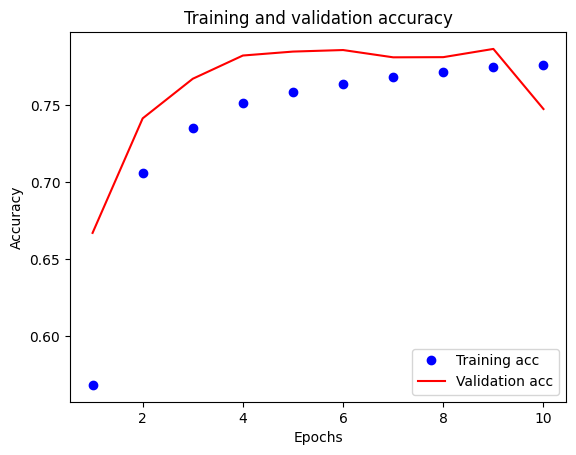

In [14]:
# VALIDATION LOSS curves

plt.clf()
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history_dict['loss']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# VALIDATION ACCURACY curves

plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, (len(history_dict['acc']) + 1))
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Predict Test

In [15]:
final_predictions = model.predict(x_test)

# Modify the raw final_predictions - prediction probs  - into 0 and 1
Preds = final_predictions.copy()
Preds[ np.where( Preds >= 0.5 ) ] = 1
Preds[ np.where( Preds < 0.5 ) ] = 0
print(Preds)

313/313 [==============================] - 1s 2ms/step
[[1.]
 [1.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]


### Results

#### Confusion matrix

Text(0.5, 0, 'Predicted label')

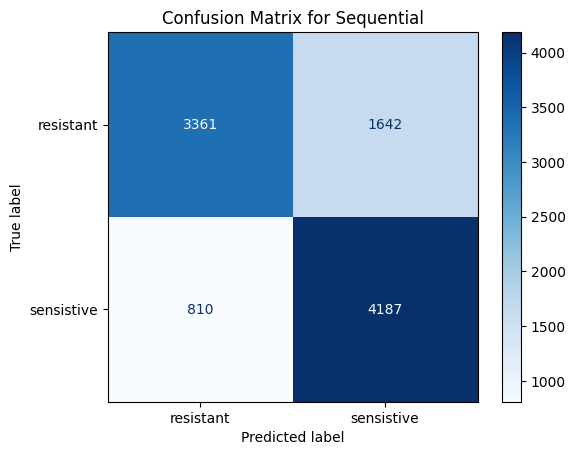

In [16]:
cm = confusion_matrix(y_test, Preds)
disp = ConfusionMatrixDisplay(cm, 
                      display_labels = ['resistant', 'sensistive'],

                      )
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Sequential')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [17]:
print ('precision: \t',precision_score(y_test, Preds))
print ('recall: \t',recall_score(y_test, Preds))
print ('accuracy: \t',accuracy_score(y_test, Preds))
print ('F1 score: \t',f1_score(y_test, Preds))

precision: 	 0.718305026591182
recall: 	 0.837902741644987
accuracy: 	 0.7548
F1 score: 	 0.7735082209495658


#### AUCROC
- AUC/ROC curves should be used when there are roughly equal numbers of observations for each class
- Precision-Recall curves should be used when there is a moderate to large class imbalance


AUC: 0.755


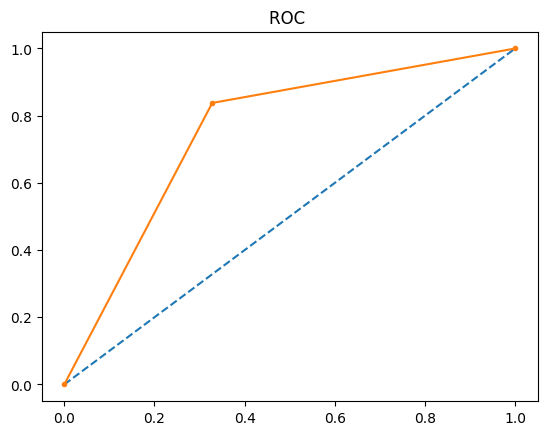

In [18]:
# calculate AUC
auc = roc_auc_score(y_test, Preds)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, Preds)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.title('ROC ')
plt.show()

# Codons instead of nucleotides

In [19]:
# From nucleotides to codons ... w/o considering the start / stop codons as the data is synthetic and may not have these

DataCod = data_df.copy()
Codons = list(data_df['genes'])

for n in range(len(Codons)):
    Codons[n] = list([Codons[n][i:i+3] for i in range(0, len(Codons[n]), 3)])
    
DataCod['codons'] = Codons
DataCod.head(3)

,resistant,genes,codons
0,False,ATGCACTACCGTATGATCCCCCTTCACTGGATGATGGAAATTGACT...,"[ATG, CAC, TAC, CGT, ATG, ATC, CCC, CTT, CAC, ..."
1,False,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...,"[ATG, CAC, TAC, CGT, ATG, ATT, CAC, TGG, ATG, ..."
2,False,ATGCACTACCGTATGATTCACTGGATCGTGATGGAAATTGACTGCA...,"[ATG, CAC, TAC, CGT, ATG, ATT, CAC, TGG, ATC, ..."


## Tokenize from codons to integers

In [20]:
maxlen = 160//3 # cut off after this number of codons in a list

max_words = 64 # considers only the top number of codons  in the dictionary (It finds 66 below because of 'a' and 'ga')
max_features = max_words

#tokenizer = Tokenizer(num_words=max_words, char_level=True)
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(list(DataCod['codons']))
sequences = tokenizer.texts_to_sequences(list(DataCod['codons']))
Xpad = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post', value=0)

print('Found %s unique tokens.' % len(tokenizer.word_index))
print('word_index', tokenizer.word_index)

Found 66 unique tokens.
word_index {'cac': 1, 'cgt': 2, 'aat': 3, 'atg': 4, 'tac': 5, 'att': 6, 'tgg': 7, 'gac': 8, 'tgc': 9, 'act': 10, 'gtt': 11, 'gaa': 12, 'aaa': 13, 'cag': 14, 'tga': 15, 'ttg': 16, 'gct': 17, 'ttc': 18, 'tct': 19, 'ggc': 20, 'aca': 21, 'taa': 22, 'ctg': 23, 'ata': 24, 'caa': 25, 'ctt': 26, 'tcg': 27, 'gtc': 28, 'aac': 29, 'gga': 30, 'acg': 31, 'gca': 32, 'tta': 33, 'cta': 34, 'acc': 35, 'gat': 36, 'tca': 37, 'tat': 38, 'agg': 39, 'tgt': 40, 'gtg': 41, 'cga': 42, 'cgc': 43, 'ttt': 44, 'aga': 45, 'ggt': 46, 'ctc': 47, 'cca': 48, 'ccg': 49, 'gcg': 50, 'a': 51, 'ga': 52, 'tag': 53, 'atc': 54, 'cat': 55, 'agt': 56, 'cgg': 57, 'aag': 58, 'gag': 59, 'cct': 60, 'gta': 61, 'ggg': 62, 'tcc': 63, 'agc': 64, 'ccc': 65, 'gcc': 66}


In [59]:
len(sequences)

100000

## Separate the label

In [21]:
labels = np.asarray(DataCod['resistant'])
print(Xpad.shape)
print(labels.shape)

(100000, 53)
(100000,)


In [22]:
# Check a sample
rowNum = 3
print(DataCod['genes'][rowNum])
print(DataCod['codons'][rowNum])
print(sequences[rowNum])
print(Xpad[rowNum])
print(labels[rowNum])

ATGCACTACCGTATGATTCACTGGGTGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA
['ATG', 'CAC', 'TAC', 'CGT', 'ATG', 'ATT', 'CAC', 'TGG', 'GTG', 'ATG', 'GAA', 'ATT', 'GAC', 'TGC', 'AAT', 'GGC', 'TGC', 'GCT', 'AAT', 'AAT', 'ACT', 'TTG', 'TCT', 'CGT', 'CGT', 'TGG', 'AAT', 'TAC', 'GAC', 'TTC', 'TGG', 'CAC', 'AAA', 'CAC', 'GTT', 'GAA', 'CAG', 'GTT', 'AAA', 'TGC', 'TAC', 'CGT', 'CAC', 'AAT', 'ATT', 'CGT', 'GAC', 'CAG', 'ACT', 'TGA']
[4, 1, 5, 2, 4, 6, 1, 7, 41, 4, 12, 6, 8, 9, 3, 20, 9, 17, 3, 3, 10, 16, 19, 2, 2, 7, 3, 5, 8, 18, 7, 1, 13, 1, 11, 12, 14, 11, 13, 9, 5, 2, 1, 3, 6, 2, 8, 14, 10, 15]
[ 4  1  5  2  4  6  1  7 41  4 12  6  8  9  3 20  9 17  3  3 10 16 19  2
  2  7  3  5  8 18  7  1 13  1 11 12 14 11 13  9  5  2  1  3  6  2  8 14
 10 15  0  0  0]
False


In [23]:
## Create train, val, and test datasets

In [24]:
training_samples = int(Xpad.shape[0] * 0.9)

indices = np.arange(Xpad.shape[0])
# np.random.shuffle(indices) # FOR TESTING PURPOSES comment it out - to keep indices as above

Xpad = Xpad[indices]
labels = labels[indices]

x_train = Xpad[:training_samples]
y_train = labels[:training_samples]
x_test = Xpad[training_samples: ]
y_test = labels[training_samples: ]

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)

x_train (90000, 53)
y_train (90000,)
x_test (10000, 53)
y_test (10000,)


## Sequential

In [25]:
# Model ... 64 CNN window 27 & Bidirectional GRU accuracy = 0.99

model = Sequential()
model.add(Embedding(64, 1, input_length=maxlen))
model.add(layers.Conv1D(128, 27, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, 9, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Bidirectional(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 53, 1)             64        
                                                                 
 conv1d_2 (Conv1D)           (None, 27, 128)           3584      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 9, 128)           0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 9, 128)            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 128)            147584    
                                                                 
 dropout_3 (Dropout)         (None, 1, 128)            0         
                                                      

In [26]:
# Train / Validate model

history = model.fit(x_train, y_train,
epochs = 10,
batch_size=32,
validation_split=0.2)

Epoch 1/10
2250/2250 [==============================] - 9s 3ms/step - loss: 0.0955 - acc: 0.9620 - val_loss: 0.0460 - val_acc: 0.9873
Epoch 2/10
2250/2250 [==============================] - 8s 3ms/step - loss: 0.0446 - acc: 0.9881 - val_loss: 0.0420 - val_acc: 0.9873
Epoch 3/10
2250/2250 [==============================] - 7s 3ms/step - loss: 0.0414 - acc: 0.9884 - val_loss: 0.0396 - val_acc: 0.9874
Epoch 4/10
2250/2250 [==============================] - 6s 3ms/step - loss: 0.0394 - acc: 0.9884 - val_loss: 0.0397 - val_acc: 0.9873
Epoch 5/10
2250/2250 [==============================] - 6s 3ms/step - loss: 0.0391 - acc: 0.9883 - val_loss: 0.0390 - val_acc: 0.9872
Epoch 6/10
2250/2250 [==============================] - 6s 3ms/step - loss: 0.0381 - acc: 0.9884 - val_loss: 0.0393 - val_acc: 0.9873
Epoch 7/10
2250/2250 [==============================] - 6s 3ms/step - loss: 0.0376 - acc: 0.9884 - val_loss: 0.0378 - val_acc: 0.9874
Epoch 8/10
2250/2250 [==============================] - 7s 3ms

### Learning curves

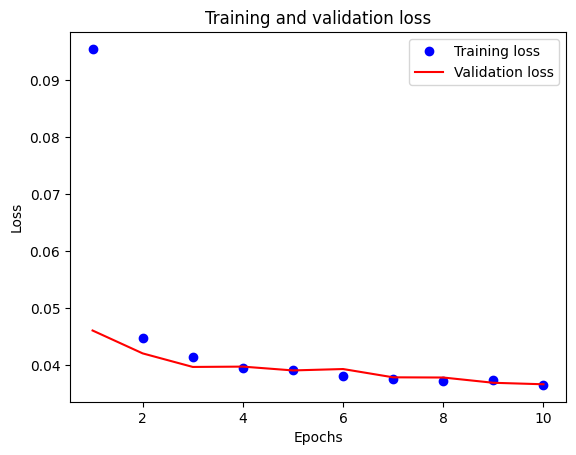

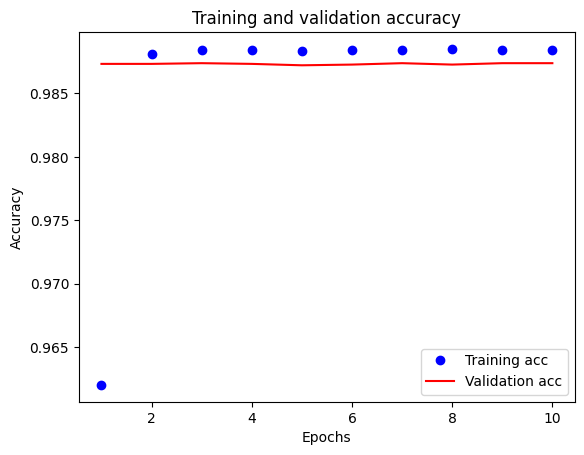

In [27]:
# VALIDATION LOSS curves

plt.clf()
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history_dict['loss']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# VALIDATION ACCURACY curves

plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, (len(history_dict['acc']) + 1))
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Predict Test

In [28]:
final_predictions = model.predict(x_test)
Preds = final_predictions.copy()
Preds[ np.where( Preds >= 0.5 ) ] = 1
Preds[ np.where( Preds < 0.5 ) ] = 0
print(Preds)

313/313 [==============================] - 0s 552us/step
[[1.]
 [1.]
 [0.]
 ...
 [1.]
 [1.]
 [0.]]


### Confusion Matrix

Text(0.5, 0, 'Predicted label')

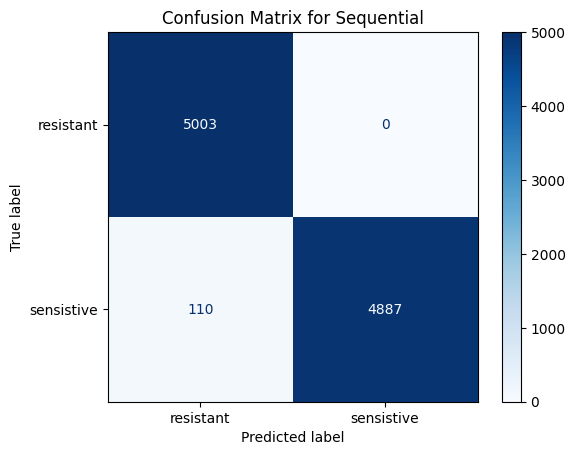

In [29]:
cm = confusion_matrix(y_test, Preds)
disp = ConfusionMatrixDisplay(cm, 
                      display_labels = ['resistant', 'sensistive'],

                      )
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Sequential')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [33]:
print ('precision: \t',precision_score(y_test, Preds))
print ('recall: \t',recall_score(y_test, Preds))
print ('accuracy: \t',accuracy_score(y_test, Preds))
print ('F1 score: \t',f1_score(y_test, Preds))

precision: 	 1.0
recall: 	 0.9779867920752452
accuracy: 	 0.989
F1 score: 	 0.9888709024686362


### AUCROC

AUC: 0.989


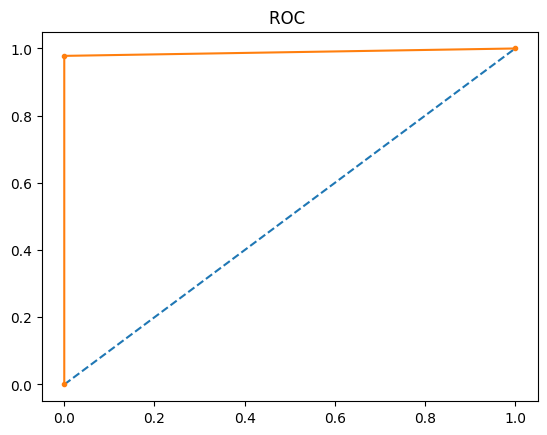

In [30]:
# calculate AUC
auc = roc_auc_score(y_test, Preds)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, Preds)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.title('ROC ')
plt.show()

# Feature Analysis

In [31]:
# import shap

# X = x_test
# y = y_test
# X_train = shap.sample(x_train, 1000)

# shap.initjs()

# # explain the model's predictions using SHAP
# # (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
# explainer = shap.KernelExplainer(model, X_train)
# shap_values = explainer.shap_values(X)

# # visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
# shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

# shap.summary_plot(shap_values, X, plot_type="bar")


In [42]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

def base_model():
    # Model ... 64 CNN window 27 & Bidirectional GRU accuracy = 0.99

    model = Sequential()
    model.add(Embedding(64, 1, input_length=maxlen))
    model.add(layers.Conv1D(128, 27, activation='relu'))
    model.add(layers.MaxPooling1D(3))
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv1D(128, 9, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Bidirectional(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return(model)

X = x_test
y = y_test
my_model = KerasRegressor(build_fn=base_model)   
my_model.fit(X,y)
perm = PermutationImportance(my_model, random_state=1).fit(X,y)

/var/folders/q7/tfct42qs0gb4h4vk7cyjyspc0000gn/T/ipykernel_85854/2625290611.py:22: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  my_model = KerasRegressor(build_fn=base_model)


313/313 [==============================] - 0s 584us/step - loss: 0.0512 - acc: 0.9854


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [101]:
print(perm.feature_importances_)
index = np.argmax(perm.feature_importances_)
print(index)

[3.13818455e-05 1.41863525e-04 6.11314908e-02 1.77579373e-04
 7.43540376e-04 3.65406275e-05 9.89963859e-04 7.06244081e-02
 1.42949224e-03 2.38472149e-03 8.83039474e-02 8.97580385e-04
 1.62931010e-03 8.12797725e-02 1.33787841e-04 1.41814798e-03
 1.87106022e-01 7.49262571e-02 3.54266241e-02 4.81011584e-02
 1.25673842e-01 8.09985757e-02 5.18915057e-04 1.82608441e-03
 6.75622076e-03 1.01648700e-01 3.52600738e-03 1.32191321e-01
 3.16403508e-03 2.33962238e-03 9.34995770e-02 2.38588378e-03
 1.05202076e-01 1.75860271e-02 4.06515062e-02 1.50700903e-01
 2.72951448e-01 1.14029613e-01 2.58970422e-01 2.02329430e-01
 1.02411261e-01 1.62671357e-03 1.92871541e-03 2.83282772e-03
 2.32339695e-02 1.47688717e-02 9.77694169e-03 1.34296012e-01
 4.30560783e-03 1.84881955e-02 8.20665061e-04 5.63416630e-04
 0.00000000e+00]
36


In [45]:

# eli5.show_weights(perm, feature_names = list(tokenizer.word_index.keys()))
eli5.show_weights(perm)

Weight,Feature
0.2730 ± 0.0124,x36
0.2590 ± 0.0135,x38
0.2023 ± 0.0193,x39
0.1871 ± 0.0112,x16
0.1507 ± 0.0141,x35
0.1343 ± 0.0113,x47
0.1322 ± 0.0162,x27
0.1257 ± 0.0050,x20
0.1140 ± 0.0162,x37
0.1052 ± 0.0065,x32


The 36th feature is the feature with the greatest weight. Determine the most common token/codon at this index

In [109]:
import collections
from collections import Counter
x35 = [x[35 - 1] for x in Xpad]
x36 = [x[36 - 1] for x in Xpad]
x37 = [x[37 - 1] for x in Xpad]
x38 = [x[38 - 1] for x in Xpad]
x39 = [x[39 - 1] for x in Xpad]
print(Counter(x35).most_common(3))
print(Counter(x36).most_common(3))
print(Counter(x37).most_common(3))
print(Counter(x38).most_common(3))
print(Counter(x39).most_common(3))

[(11, 48640), (12, 7475), (1, 6705)]
[(12, 47165), (11, 13137), (14, 7480)]
[(14, 47275), (11, 13174), (12, 6705)]
[(11, 48737), (13, 7483), (14, 6705)]
[(13, 47313), (9, 7484), (11, 6705)]


In [110]:
items = list(d.items())
print(items[11-1])
print(items[12-1])
print(items[13-1])
print(items[14-1])

('gtt', 11)
('gaa', 12)
('aaa', 13)
('cag', 14)


In [149]:
string_search = (items[11-1][0] + items[12-1][0]).upper()
string_search

'GTTGAA'

In [151]:
proportion = sum(string_search in s for s in data_df['genes']) / len(data_df['genes'])
proportion

0.9818

In [155]:
Counter([s[12*3-1: 13*3-1+ 3] for s in data_df['genes']]).most_common(5)


[('TGACTG', 47100),
 ('CAATGG', 6409),
 ('CTGCAA', 6033),
 ('AATTGA', 5062),
 ('GGAAAT', 4327)]